In [1]:
import snowflake.connector
import os
conn = snowflake.connector.connect(
    user=os.environ['SNOWFLAKE_USER'],
    role=os.environ['SNOWFLAKE_ROLE'],
    password=os.environ['SNOWFLAKE_PASSWORD'],
    account=os.environ['SNOWFLAKE_ACCOUNT'],
    warehouse=os.environ['SNOWFLAKE_WAREHOUSE'],
    database=os.environ['SNOWFLAKE_DATABASE'],
    schema=os.environ['SNOWFLAKE_SCHEMA']
)



In [2]:
# %conda install "snowflake-connector-python[pandas]"


In [7]:
# Create a cursor object.
import pandas as pd
def run_sql(sql: str, ctx=conn):
    return conn.cursor().execute(sql)

def sql_to_df(sql_query, pre_hook=[], ctx=conn):
    print(f"RUNNING pre-hook: {pre_hook}")
    for s in pre_hook:
        run_sql(s,conn)
        # print(f"RUNNING SQL: {sql_query}")

    # todo: move to latest method of pandas dataframe fetching
    # may need to upgrade python: https://github.com/snowflakedb/snowflake-connector-python/issues/986#issuecomment-1115354587
    
    trimmed_lowered = sql_query.strip().lower()
    if trimmed_lowered.startswith('select') or trimmed_lowered.startswith('with'):
        print(f"using arrow to fetch results...")
        cur = ctx.cursor()
        cur.execute(sql_query)
        data = cur.fetch_pandas_all() 
        cur.close()
    else:
        data = pd.read_sql(
            sql_query,
            ctx,
        )
    
    data.columns = data.columns.str.lower()
    return data

In [22]:
%%markdown
# Idle Time 

# Idle Time 


RUNNING pre-hook: []
using arrow to fetch results...


auto_suspend  warehouse_id                     warehouse_name  \
60           NaN           102                EBATES_CA_ODS_DE_WH   
59           NaN           104               REBATES_JP_ODS_DE_WH   
61           NaN           185                    FOUNDATION_2_WH   
62           NaN           222  ENRICH_SCIENCE_ENGG_FORECAST_1_WH   
63           NaN             4                         TABLEAU_WH   
..           ...           ...                                ...   
35           NaN           123                    MESSAGE_GEAR_WH   
43           NaN           144                CAMPAIGN_ADMIN_1_WH   
33           NaN            24                     PLATFORM_DE_WH   
44           NaN            61                        SALES_BU_WH   
32           NaN             7                         ATSCALE_WH   

                  warehouse_sizes  max_cluster_number  active_hours  \
60              [\n  "X-Small"\n]                   1      0.068124   
59              [\n  "X-Small"\n]                   1      0.077212   
61               [\n  "Medium"\n]                   1      0.034183   
62               [\n  "Medium"\n]                   1      0.041320   
63               [\n  "Medium"\n]                   1      0.113943   
..                            ...                 ...           ...   
35               [\n  "Medium"\n]                   4    347.321481   
43               [\n  "Medium"\n]                   5    459.275916   
33                [\n  "Large"\n]                   2    432.239032   
44                [\n  "Large"\n]                   2    305.093959   
32  [\n  "X-Large",\n  "Large"\n]                   5    175.805648   

    idle_hours   pct_idle  credits_used_compute  credits_used_inferred  \
60    0.067242  98.704577              0.068889               0.068124   
59    0.075659  97.988934              0.078056               0.077212   
61    0.016856  49.310894              0.137778               0.136731   
62    0.016890  40.875417              0.165556               0.165280   
63   -0.059200 -51.955777              0.456667               0.455772   
..         ...        ...                   ...                    ...   
35  160.825499  46.304507           2567.685556            1389.285924   
43   59.424855  12.938814           2996.334167            1837.103664   
33  180.661856  41.796747           3614.275278            3457.912256   
44   34.703401  11.374660           3728.968333            2440.751669   
32   72.912670  41.473451           4488.688056            2352.819711   

    pccredit_estimation_error  credits_used_addtl_clusters  credits_used_idle  \
60                  -1.109676                     0.000000           0.067996   
59                  -1.081138                     0.000000           0.076486   
61                  -0.759678                     0.000000           0.067939   
62                  -0.166443                     0.000000           0.067672   
63                  -0.195864                     0.000000          -0.237265   
..                        ...                          ...                ...   
35                 -45.893456                  1178.399631         643.301997   
43                 -38.688292                  1159.230502         237.699420   
33                  -4.326262                   156.363022        1445.294851   
44                 -34.546195                  1288.216664         277.627204   
32                 -47.583354                  2135.868344         975.795542   

    credits_used_active  
60             0.000892  
59             0.001570  
61             0.069838  
62             0.097884  
63             0.693931  
..                  ...  
35          1396.952978  
43          2611.304770  
33          2126.849235  
44          3358.684050  
32          2968.820925  

[129 rows x 14 columns]

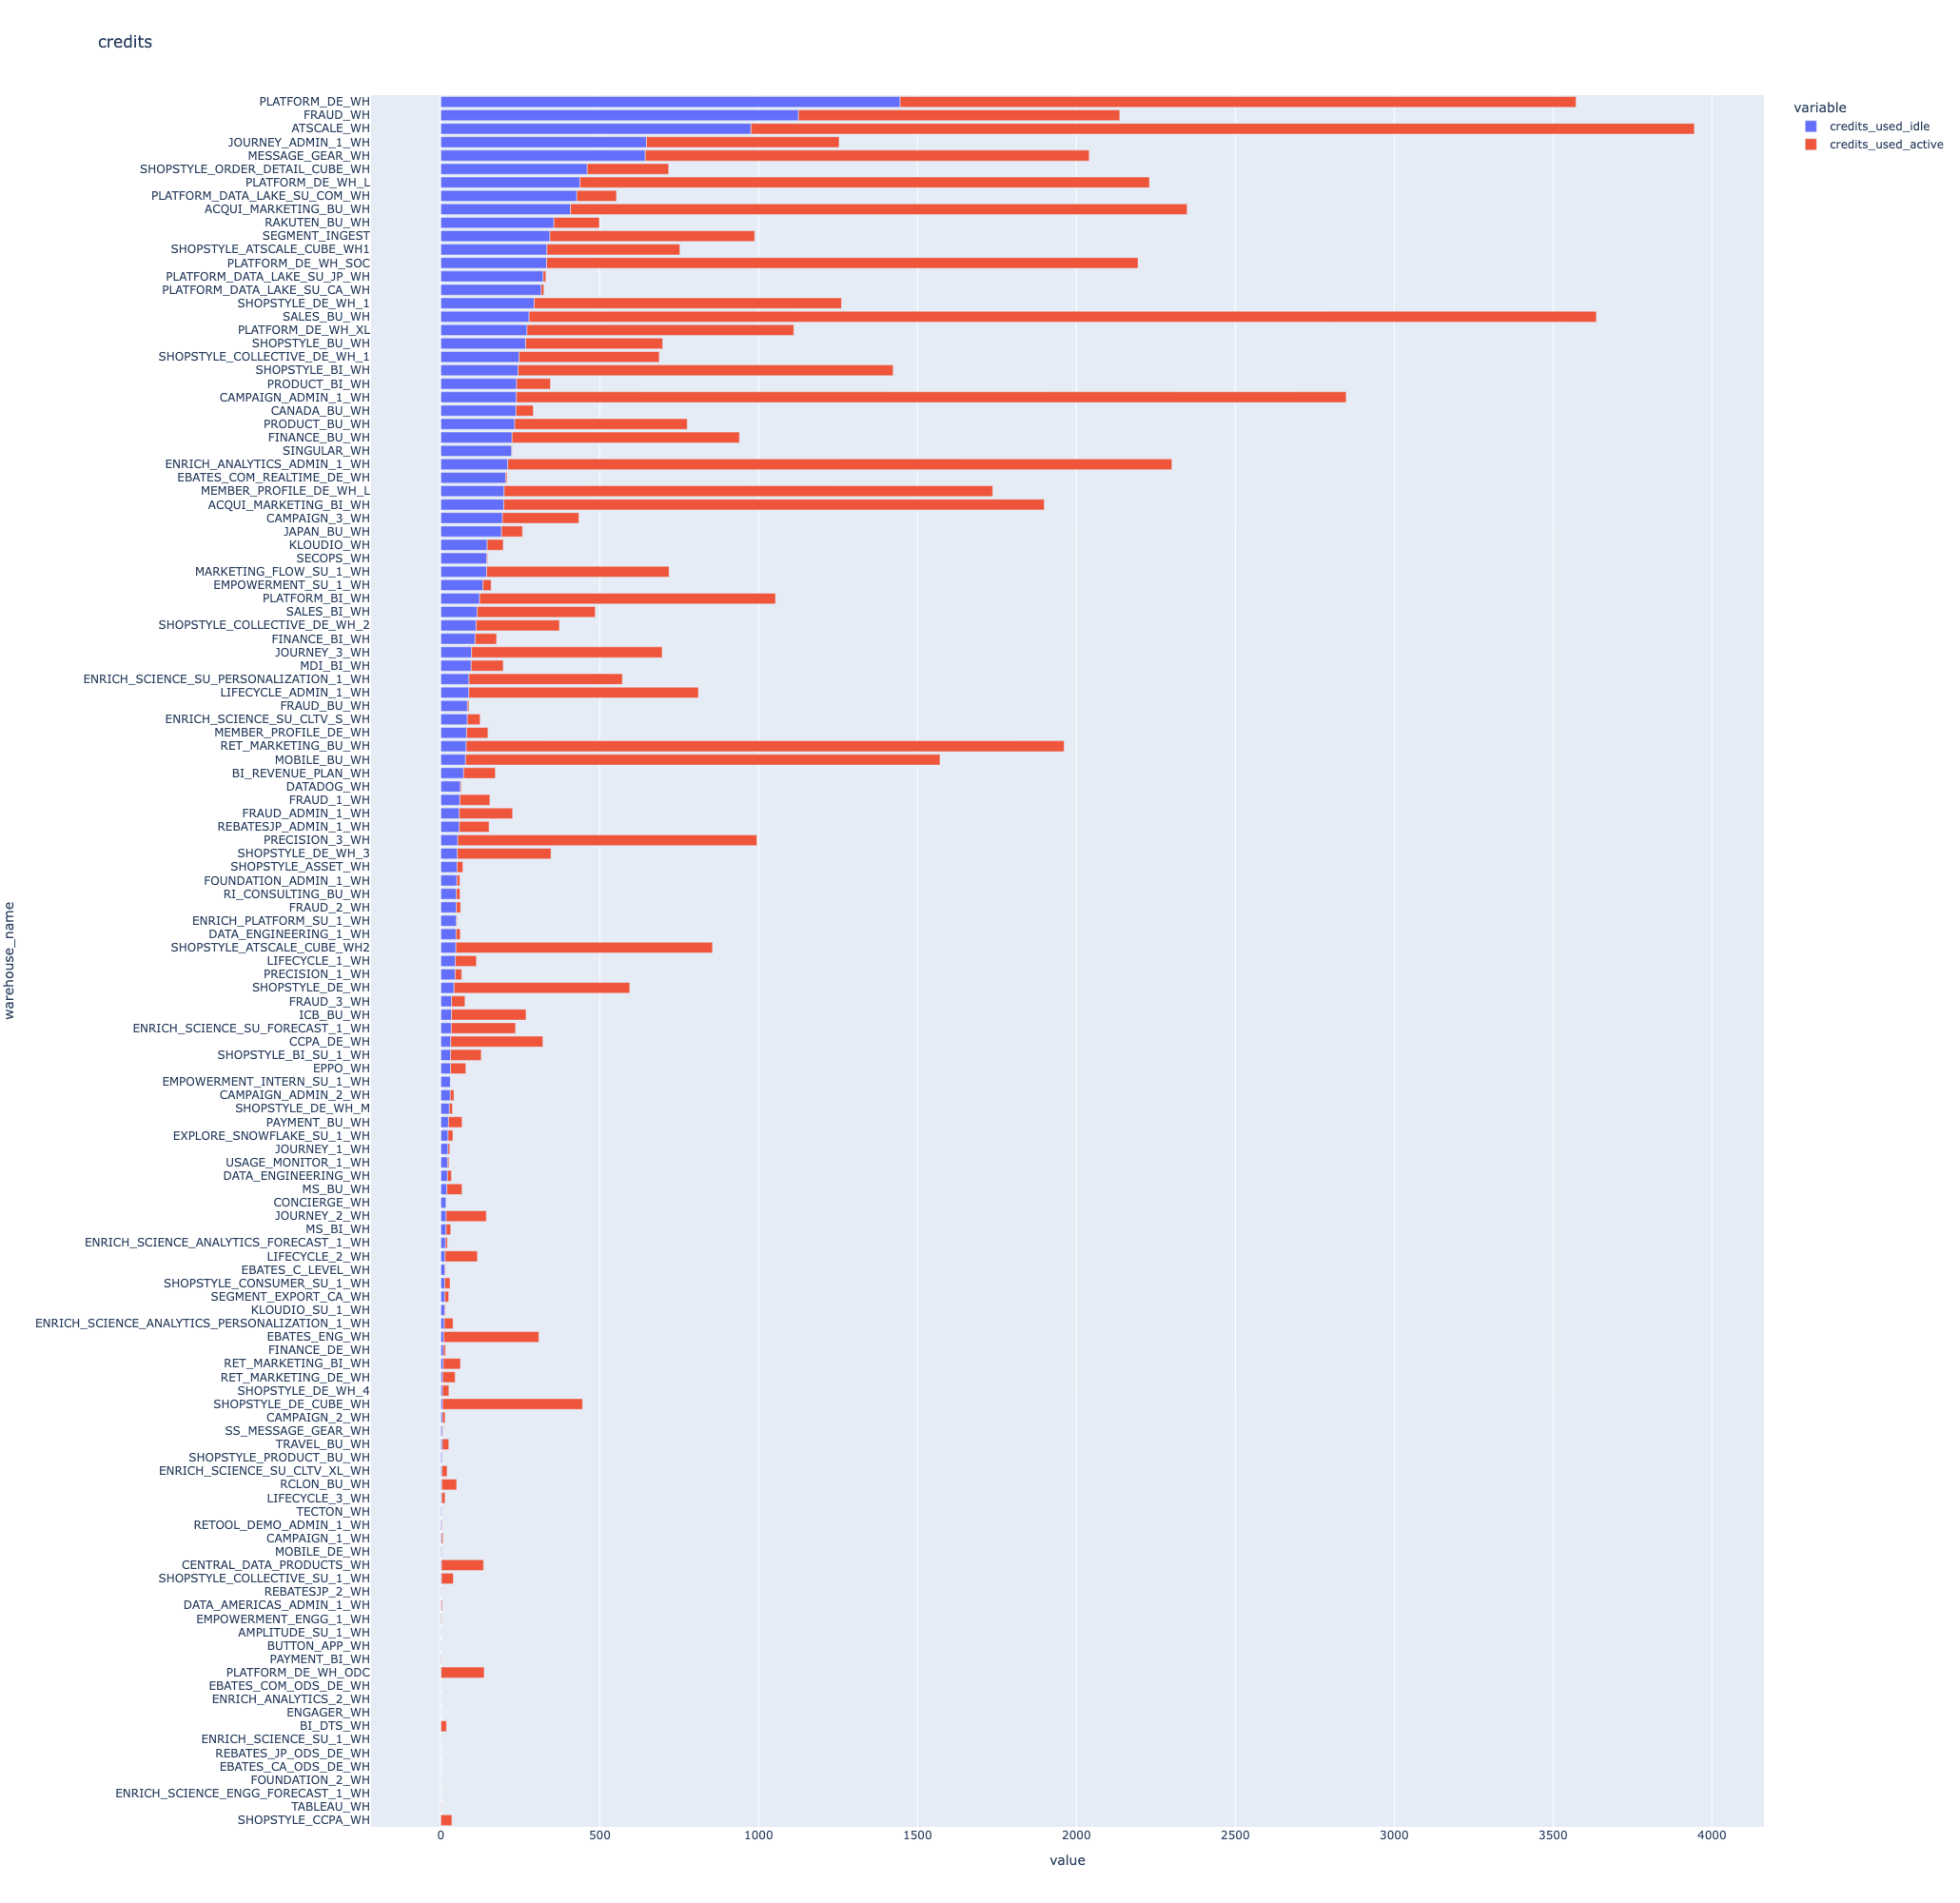

In [13]:
from IPython.display import display
import plotly.express as px

sql = """
    select 
        * exclude credits_used_idle, 
        case when max_cluster_number = 1 then 0 else credits_used_compute - credits_used_inferred end as credits_used_addtl_clusters,
        (credits_used_compute - credits_used_addtl_clusters) *pct_idle/100 as credits_used_idle,
        credits_used_compute - credits_used_idle as credits_used_active
    from warehouse_profile
"""
df = sql_to_df(sql)
display(df.sort_values('credits_used_compute'))
fig = px.bar(
    df.sort_values('credits_used_idle', ascending=True), 
    y="warehouse_name", 
    x=["credits_used_idle", 'credits_used_active'], 
    # color = 'wh_utilization_status', 
    # color_discrete_sequence=['blue', 'green', 'red'],
    title = "credits",
    orientation='h',
    height=2000
)
fig.show()

# fig = px.bar(
#     df.sort_values('pct_idle', ascending=True), 
#     y="warehouse_name", 
#     x='pct_idle', 
#     # color = 'wh_utilization_status', 
#     # color_discrete_sequence=['blue', 'green', 'red'],
#     title = "credits",
#     orientation='h',
#     height=2000
# )
# fig.show()

In [25]:
%%markdown
## --> some warehouses have significant idle time. This could be cut with more aggressive shutdowns and/or packing workloads onto fewer warehouses.

## --> some warehouses have significant idle time. This could be cut with more aggressive shutdowns and/or packing workloads onto fewer warehouses.


In [28]:
%%markdown
# Warehouse Resource Utilization
### Search for warehouses with queries that could be run on a smaller warehouse
### This would motivate resizing the warehouse or moving those queries to a smaller warehouse.

# Warehouse Resource Utilization
### Search for warehouses with queries that could be run on a smaller warehouse
### This would motivate resizing the warehouse or moving those queries to a smaller warehouse.


RUNNING pre-hook: []
using arrow to fetch results...


warehouse_name wh_utilization_status  status_id     cnt  \
0                 TRAVEL_BU_WH         underutilized          0       7   
1                 TRAVEL_BU_WH           right-sized          1      36   
2                PAYMENT_BI_WH         underutilized          0      13   
3                PAYMENT_BI_WH           right-sized          1      57   
4    EXPLORE_SNOWFLAKE_SU_1_WH         underutilized          0      63   
..                         ...                   ...        ...     ...   
251       SHOPSTYLE_DE_CUBE_WH           right-sized          1     125   
252             PLATFORM_DE_WH         underutilized          0   62676   
253             PLATFORM_DE_WH           right-sized          1   49368   
254            MESSAGE_GEAR_WH         underutilized          0  150297   
255            MESSAGE_GEAR_WH           right-sized          1  132922   

     total_query_cost  underutilized_cost  
0            0.000107            0.000107  
1           49.151747            0.000107  
2            0.029752            0.029752  
3            3.379148            0.029752  
4            0.045941            0.045941  
..                ...                 ...  
251        881.223750          881.223750  
252        882.181814          882.181814  
253       6280.908742          882.181814  
254        904.676530          904.676530  
255       4189.607273          904.676530  

[256 rows x 6 columns]

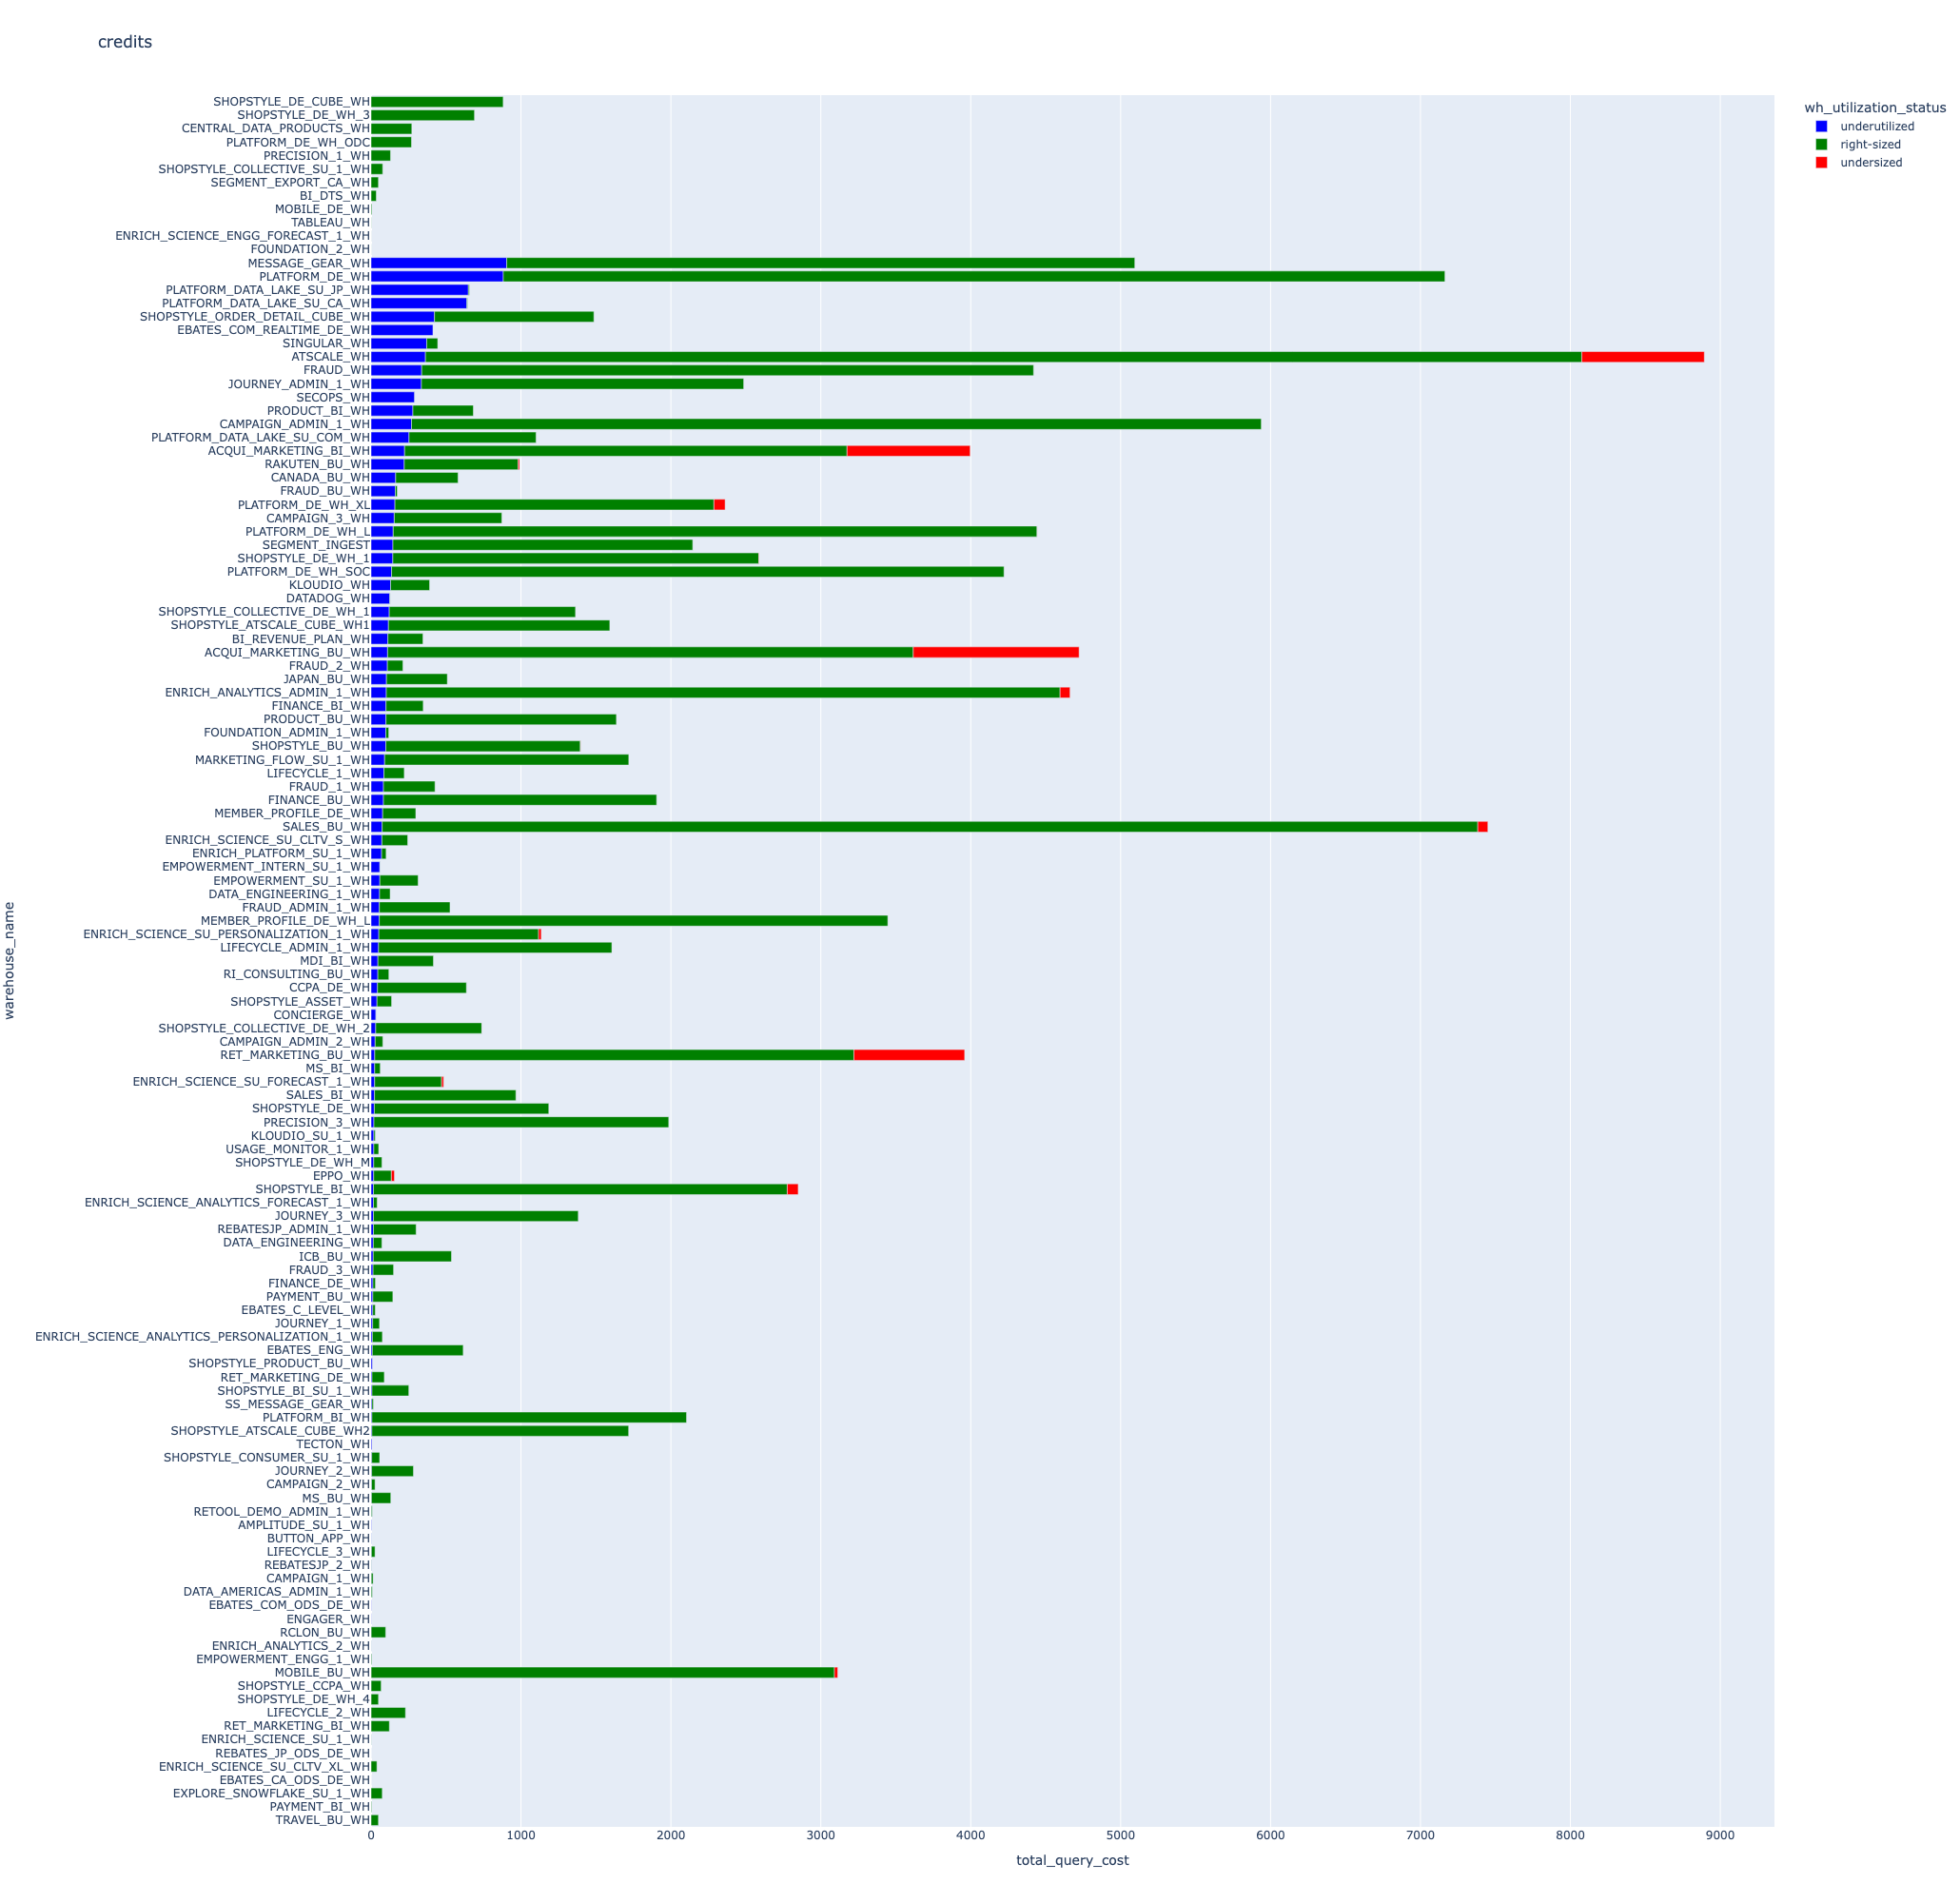

In [18]:
from IPython.display import display

sql = """
with a as (
select
    warehouse_name,
    wh_utilization_status,
    (case when wh_utilization_status = 'underutilized' then 0 
when wh_utilization_status = 'right-sized' then 1 
else 2 end) as status_id,
    count(*) cnt,
    sum(query_cost) total_query_cost
from query_history_narrowed
group by 
    warehouse_name,
    wh_utilization_status
)
select 
    *,
        first_value(total_query_cost) over (partition by warehouse_name order by status_id) as underutilized_cost
from a
order by underutilized_cost asc, warehouse_name, status_id
"""
df = sql_to_df(sql)
display(df)
fig = px.bar(
    df, 
    y="warehouse_name", 
    x="total_query_cost", 
    color = 'wh_utilization_status', 
    color_discrete_sequence=['blue', 'green', 'red'],
    title = "credits",
    orientation='h',
    height=2000
)
fig.show()


In [ ]:
%%markdown
## --> There aren't any warehouses that have a large pct of spend on 

In [3]:
sql = """
with underutilizing_query_cost as (
    select
        warehouse_id,
        warehouse_name,
        -- wh_utilization_status,
        count(*) cnt,
        sum(query_cost) total_query_cost
    from query_history_narrowed
    where wh_utilization_status = 'underutilized'
    group by 
        warehouse_id, warehouse_name
),
idle_cost as (
    select 
        * exclude credits_used_idle, 
        case when max_cluster_number = 1 then 0 else credits_used_compute - credits_used_inferred end as credits_used_addtl_clusters,
        (credits_used_compute - credits_used_addtl_clusters) *pct_idle/100 as credits_used_idle,
        credits_used_compute - credits_used_idle as credits_used_active
    from warehouse_profile
    -- order by credits_used_idle desc
),
wh_load as (
    select 
        warehouse_id,
        warehouse_name,
        avg(avg_running) avg_running,
        avg(avg_queued_load) avg_queued_load,
        median(avg_queued_load) median_queued_load
    from 
        stg_warehouse_load_history
    where start_time > (select min(start_time) from query_history_narrowed)
    group by 1,2
)
select 
    i.*,
    w.avg_running,
    w.avg_queued_load,
    median_queued_load,
    coalesce(u.cnt, 0) as cnt,
    coalesce(u.total_query_cost, 0) as underutilized_query_spend,
    
    credits_used_idle + underutilized_query_spend as estimated_waste_total,
    credits_used_idle*0.2 + underutilized_query_spend*0.5 as estimated_cost_savings,
    100*estimated_cost_savings/credits_used_compute as estimated_cost_savings_pct
from idle_cost i
full outer join underutilizing_query_cost  u
on i.warehouse_name = u.warehouse_name and i.warehouse_id = u.warehouse_id
left join wh_load w
on i.warehouse_name = w.warehouse_name and i.warehouse_id = w.warehouse_id
order by estimated_waste_total desc
;
"""

df = sql_to_df(sql, ['set lookback_days=30'])
df

RUNNING pre-hook: ['set lookback_days=30']
RUNNING SQL: 
with underutilizing_query_cost as (
    select
        warehouse_id,
        warehouse_name,
        -- wh_utilization_status,
        count(*) cnt,
        sum(query_cost) total_query_cost
    from query_history_narrowed
    where wh_utilization_status = 'underutilized'
    group by 
        warehouse_id, warehouse_name
),
idle_cost as (
    select 
        * exclude credits_used_idle, 
        case when max_cluster_number = 1 then 0 else credits_used_compute - credits_used_inferred end as credits_used_addtl_clusters,
        (credits_used_compute - credits_used_addtl_clusters) *pct_idle/100 as credits_used_idle,
        credits_used_compute - credits_used_idle as credits_used_active
    from warehouse_profile
    -- order by credits_used_idle desc
),
wh_load as (
    select 
        warehouse_id,
        warehouse_name,
        avg(avg_running) avg_running,
        avg(avg_queued_load) avg_queued_load,
        median(avg_queued

auto_suspend  warehouse_id                     warehouse_name  \
0             NaN            24                     PLATFORM_DE_WH   
1             NaN           123                    MESSAGE_GEAR_WH   
2             NaN            93                           FRAUD_WH   
3             NaN             7                         ATSCALE_WH   
4             NaN           173                 JOURNEY_ADMIN_1_WH   
..            ...           ...                                ...   
124           NaN           102                EBATES_CA_ODS_DE_WH   
125           NaN           185                    FOUNDATION_2_WH   
126           NaN           222  ENRICH_SCIENCE_ENGG_FORECAST_1_WH   
127           NaN           140                  SHOPSTYLE_CCPA_WH   
128           NaN             4                         TABLEAU_WH   

                   warehouse_sizes  max_cluster_number  active_hours  \
0                  [\n  "Large"\n]                   2    432.239032   
1                 [\n  "Medium"\n]                   5    347.321481   
2                  [\n  "Large"\n]                   2    245.466991   
3    [\n  "X-Large",\n  "Large"\n]                   5    175.805648   
4                 [\n  "Medium"\n]                   1    312.037087   
..                             ...                 ...           ...   
124              [\n  "X-Small"\n]                   1      0.068124   
125               [\n  "Medium"\n]                   1      0.034183   
126               [\n  "Medium"\n]                   1      0.041320   
127                [\n  "Large"\n]                   1      4.245361   
128               [\n  "Medium"\n]                   1      0.113943   

     idle_hours   pct_idle  credits_used_compute  credits_used_inferred  ...  \
0    180.661856  41.796747           3614.275278            3457.912256  ...   
1    160.825499  46.304507           2567.685556            1389.285924  ...   
2    140.664167  57.304718           2227.284722            1963.735924  ...   
3     72.912670  41.473451           4488.688056            2352.819711  ...   
4    161.012222  51.600348           1253.892778            1248.148349  ...   
..          ...        ...                   ...                    ...  ...   
124    0.067242  98.704577              0.068889               0.068124  ...   
125    0.016856  49.310894              0.137778               0.136731  ...   
126    0.016890  40.875417              0.165556               0.165280  ...   
127   -0.064288  -1.514306             33.975556              33.962889  ...   
128   -0.059200 -51.955777              0.456667               0.455772  ...   

     credits_used_idle  credits_used_active     avg_running  avg_queued_load  \
0          1445.294851          2126.849235  0.586778260227   0.000039952956   
1           643.301997          1396.952978  1.019972128277   0.031342631714   
2          1125.313336          1010.909485  0.368569197523   0.000076062826   
3           975.795542          2968.820925  1.540342674135   0.032408436978   
4           647.013033           606.246584  0.260695623842   0.036287286421   
..                 ...                  ...             ...              ...   
124           0.067996             0.000892  0.005763333250            0E-12   
125           0.067939             0.069838  0.214130000000            0E-12   
126           0.067672             0.097884  0.043944999875            0E-12   
127          -0.514494            34.472974  0.803699227058            0E-12   
128          -0.237265             0.693931  1.039943333000            0E-12   

    median_queued_load     cnt  underutilized_query_spend  \
0              0.00000   62676                 882.181814   
1              0.00079  150297                 904.676530   
2              0.00000    7283                 337.666475   
3              0.00000   20119                 362.842830   
4              0.00000   26706                 336.137469   
..         

In [4]:
# top five from above list; highest potential savings
candidates = [
    'PLATFORM_DE_WH',
    'MESSAGE_GEAR_WH',
    'FRAUD_WH',
    'ATSCALE_WH',
    'JOURNEY_ADMIN_1_WH'
]

RUNNING pre-hook: ['set lookback_days=30']
RUNNING SQL: 
with qhe as (
select 
    *    
from
    qhe_lookback
),
stats as (
select
    warehouse_name,
    date_trunc('day', execution_start_time) date,
    wh_utilization_status,
    count(*) cnt,
    sum(query_cost) total_query_cost
from qhe
group by 
    warehouse_name,date,
    wh_utilization_status
),
wh_utilization_by_date as (
select 
    *,
    100*ratio_to_report(cnt) over (partition by warehouse_name, date) as pct_cnt,
    100*ratio_to_report(total_query_cost) over (partition by warehouse_name, date) as pct_total_query_cost
from stats
)
select * from wh_utilization_by_date
order by warehouse_name, 
(case when wh_utilization_status = 'underutilized' then 0 
when wh_utilization_status = 'right-sized' then 1 
else 2 end) asc

using arrow to fetch results...


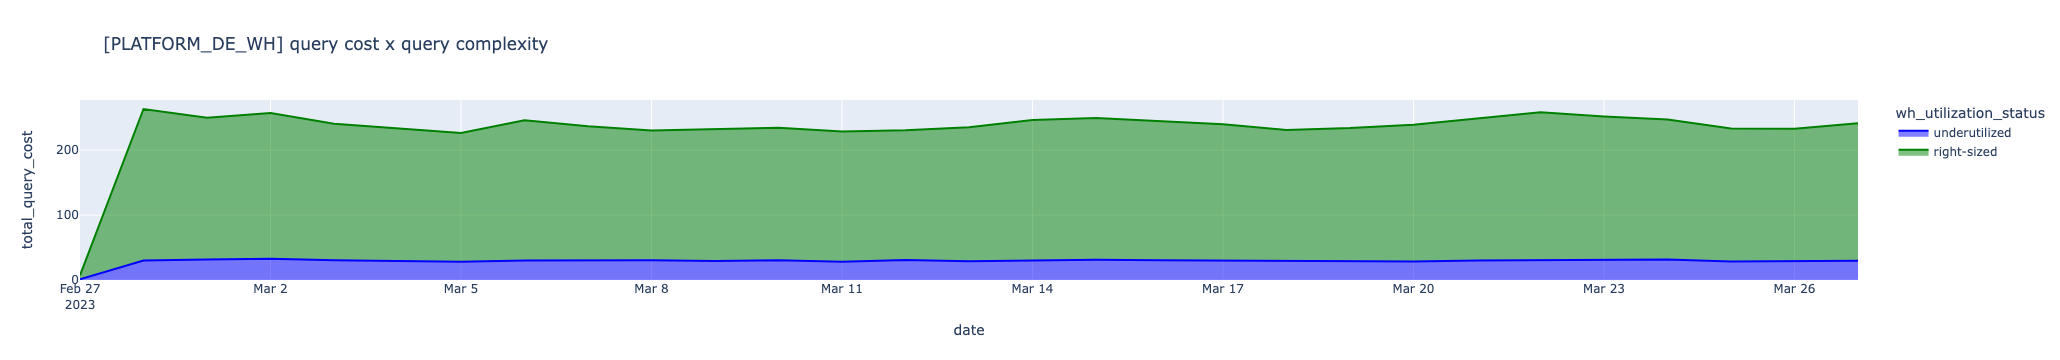

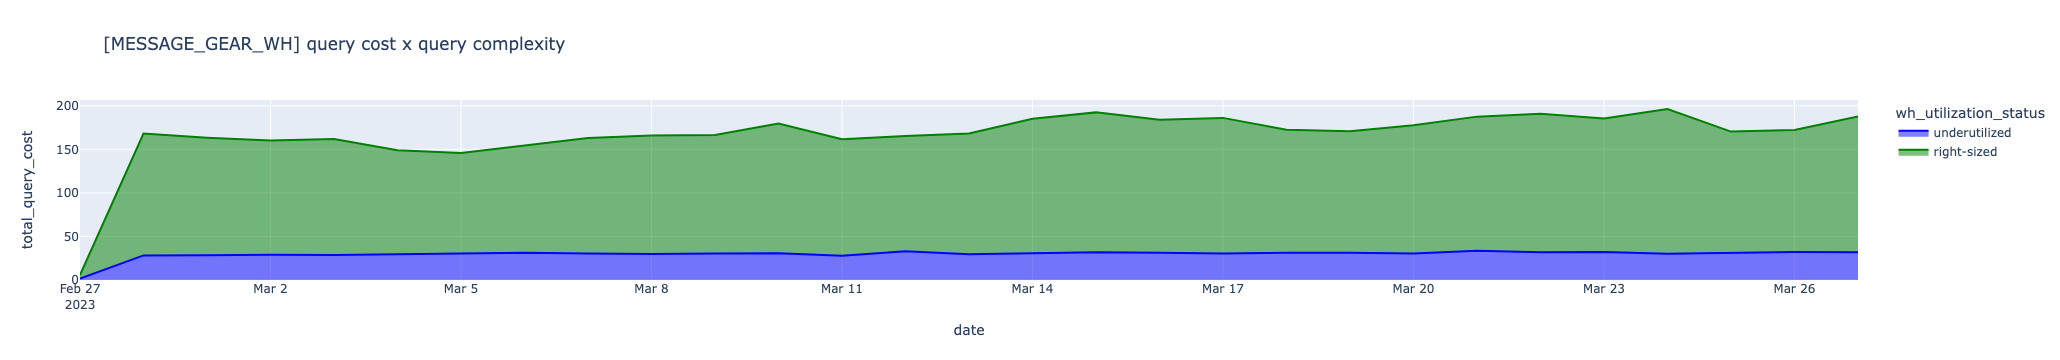

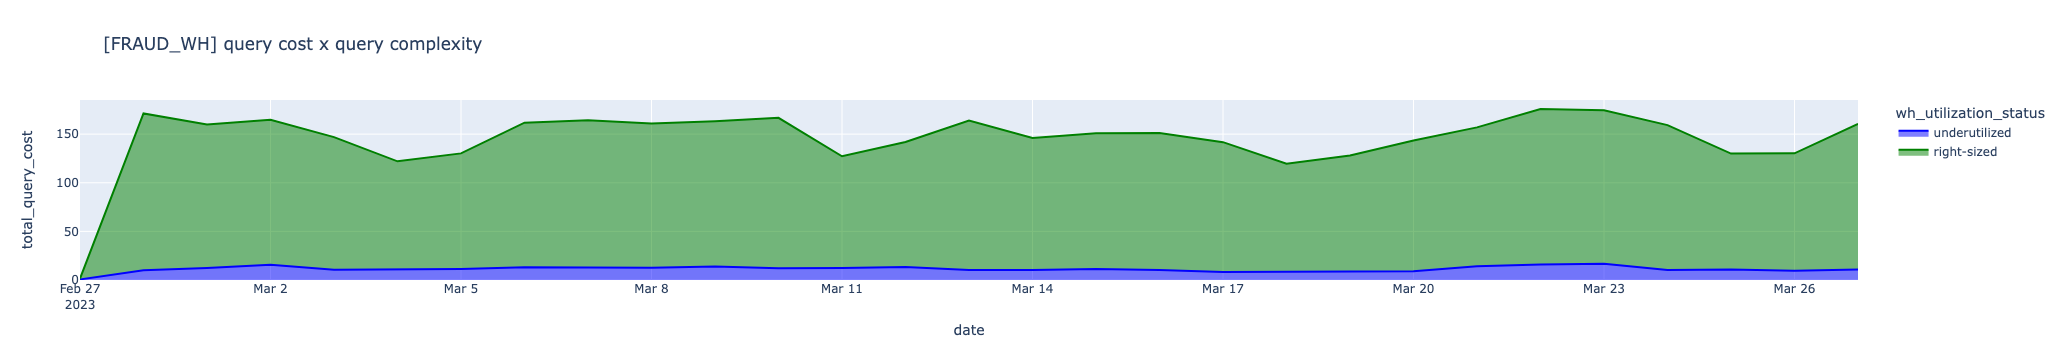

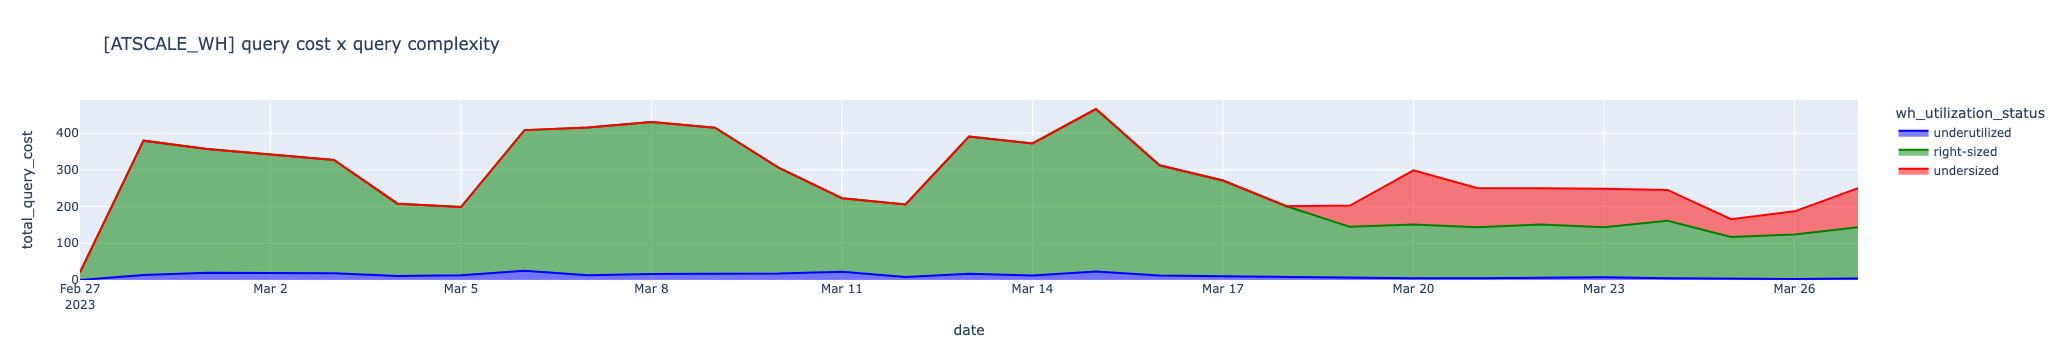

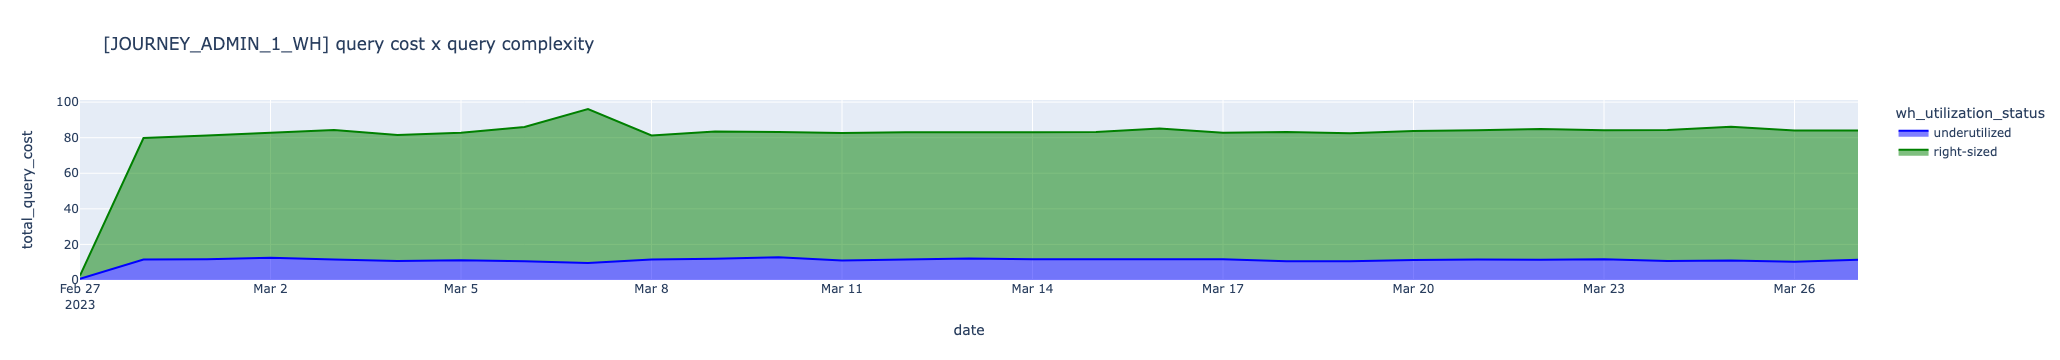

In [6]:
sql = """
with qhe as (
select 
    *    
from
    qhe_lookback
),
stats as (
select
    warehouse_name,
    date_trunc('day', execution_start_time) date,
    wh_utilization_status,
    count(*) cnt,
    sum(query_cost) total_query_cost
from qhe
group by 
    warehouse_name,date,
    wh_utilization_status
),
wh_utilization_by_date as (
select 
    *,
    100*ratio_to_report(cnt) over (partition by warehouse_name, date) as pct_cnt,
    100*ratio_to_report(total_query_cost) over (partition by warehouse_name, date) as pct_total_query_cost
from stats
)
select * from wh_utilization_by_date
order by warehouse_name, 
(case when wh_utilization_status = 'underutilized' then 0 
when wh_utilization_status = 'right-sized' then 1 
else 2 end) asc
"""
df = sql_to_df(sql, ['set lookback_days=30'])
import plotly.express as px

for wh in candidates:
    fig = px.area(
        df[df.warehouse_name == wh], 
        x="date", 
        y="total_query_cost", 
        color = 'wh_utilization_status', 
        color_discrete_sequence=['blue', 'green', 'red'],
        title = f"[{wh}] query cost x query complexity"
    )
    fig.update_layout(hovermode="x")
    fig.show()

    # fig = px.area(
    #     df[df.warehouse_name == wh], 
    #     x="date", 
    #     y="cnt", 
    #     color = 'wh_utilization_status', 
    #     color_discrete_sequence=['blue', 'green', 'red'],
    #     title = "query count"
    # )
    # fig.update_layout(hovermode="x")
    # fig.show()

In [6]:
df[df.warehouse_name == wh]

NameError: name 'wh' is not defined

In [ ]:
# %%jupyter labextension install jupyterlab-plotly

In [ ]:
# %conda install jupyterlab-plotly



In [25]:
len(warehouses)

129

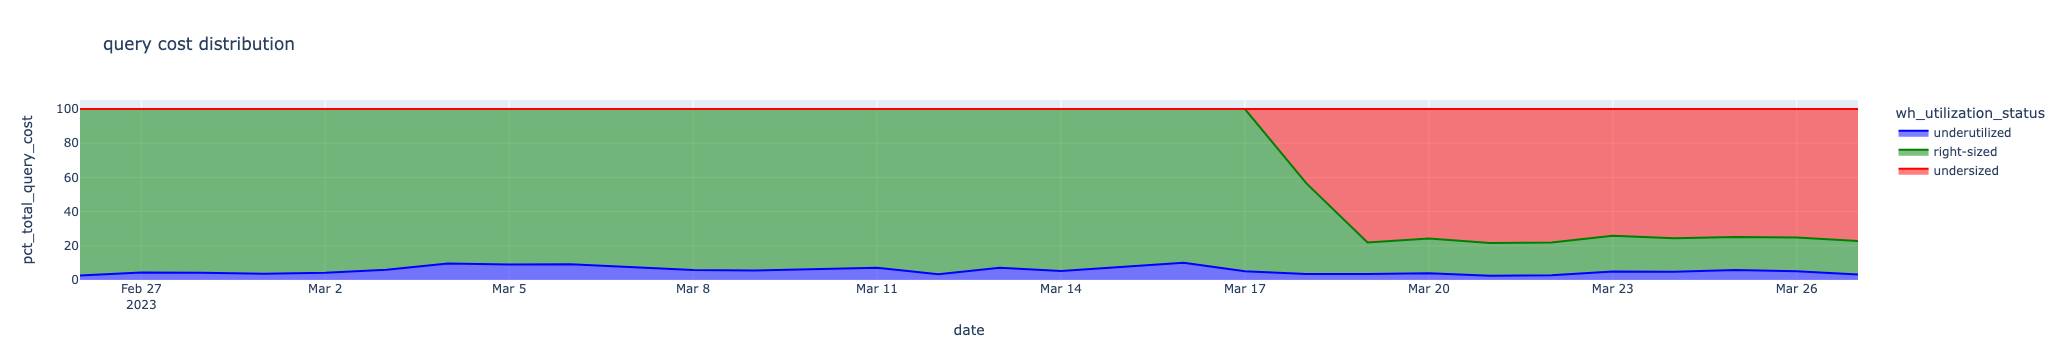

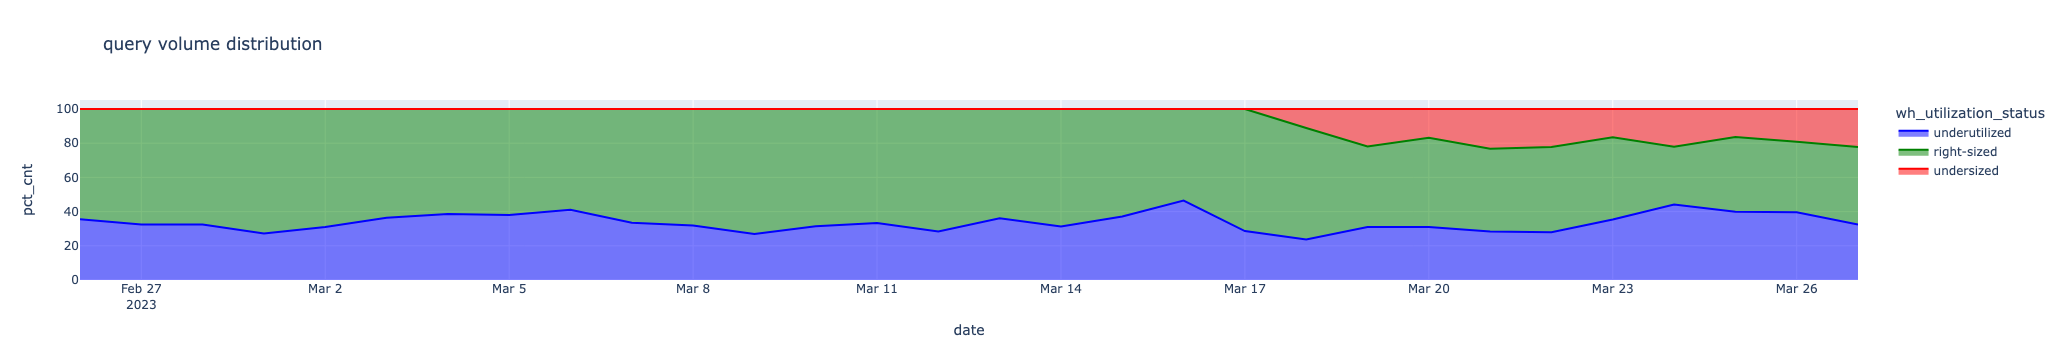

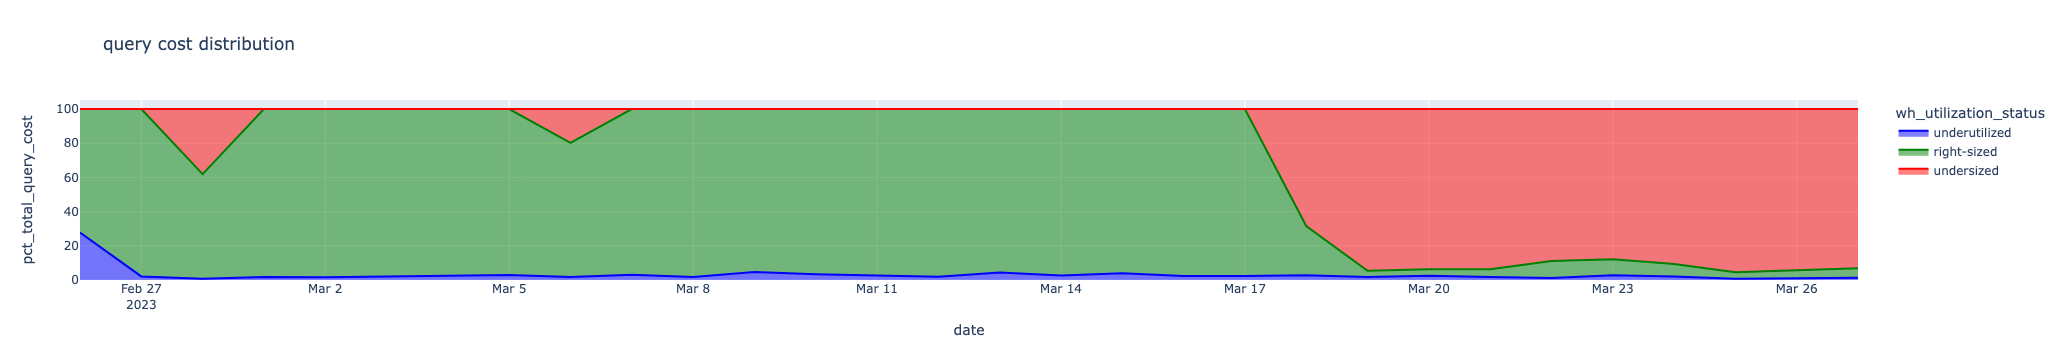

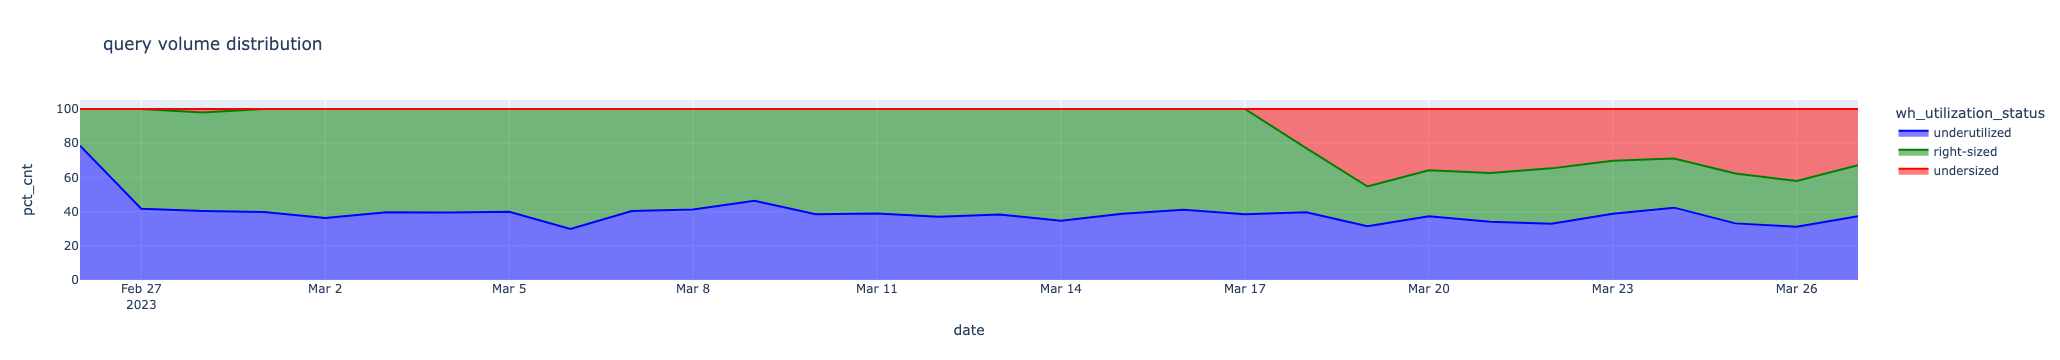

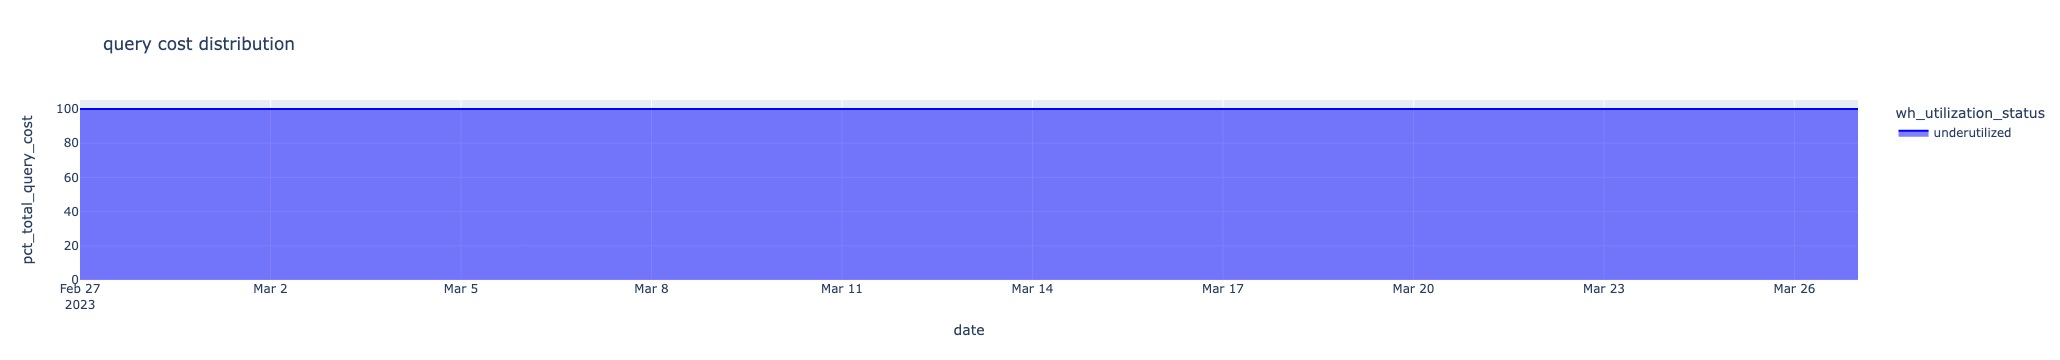

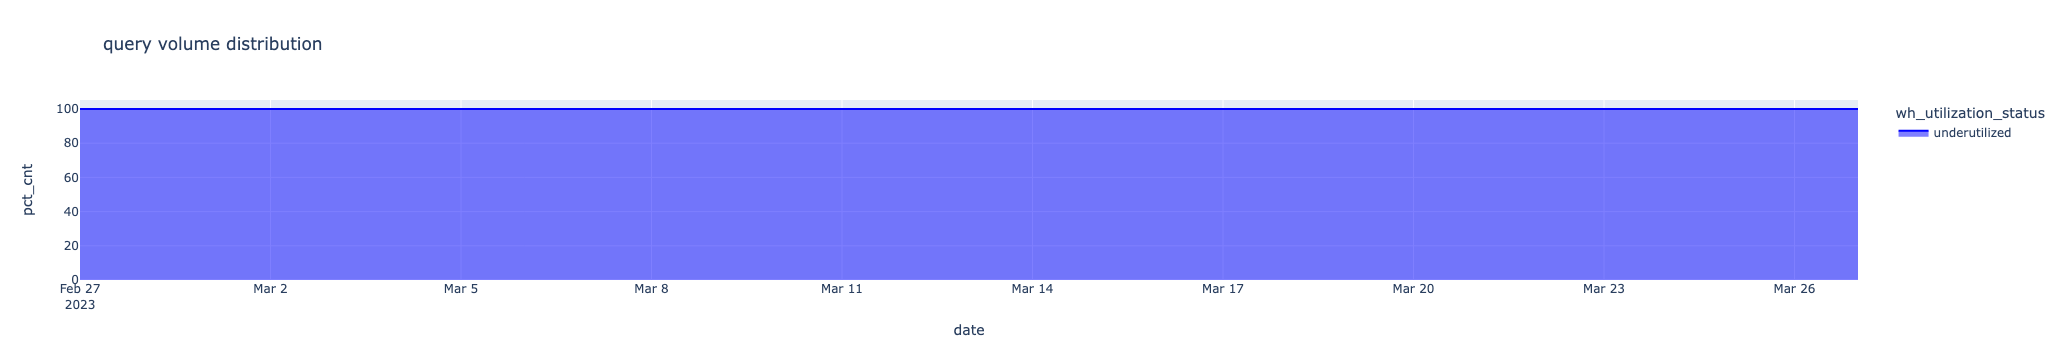

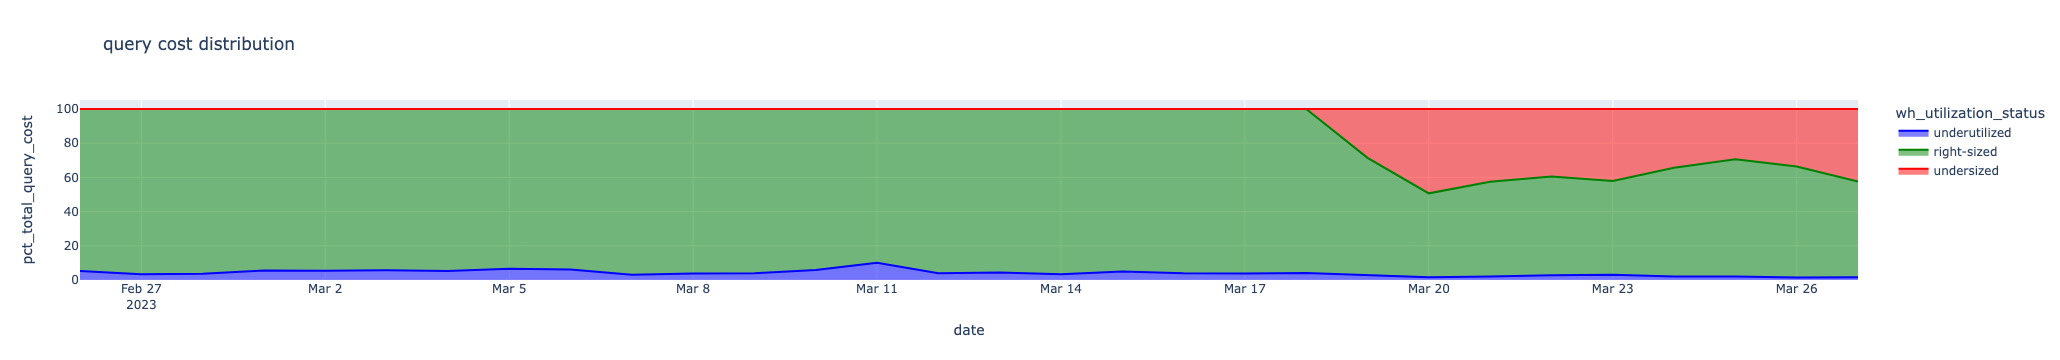

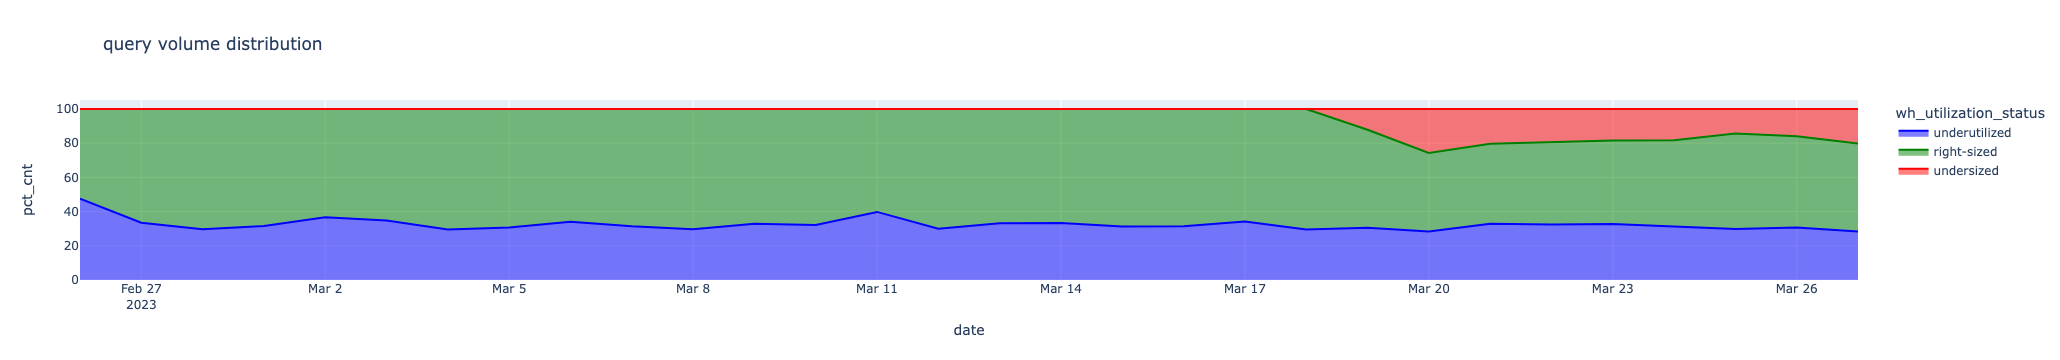

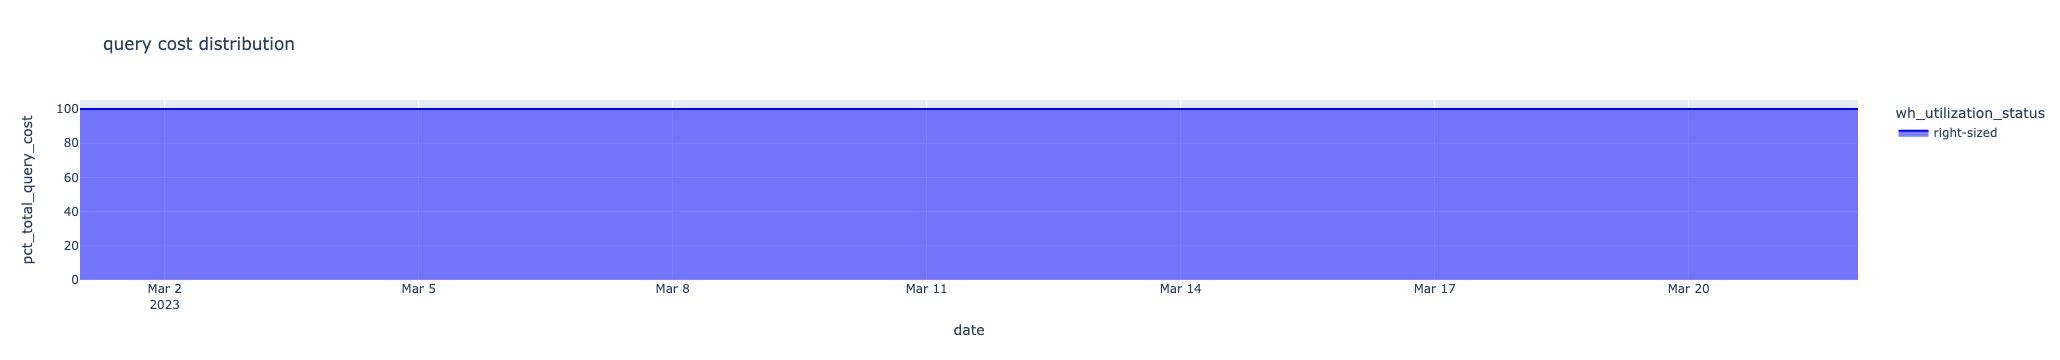

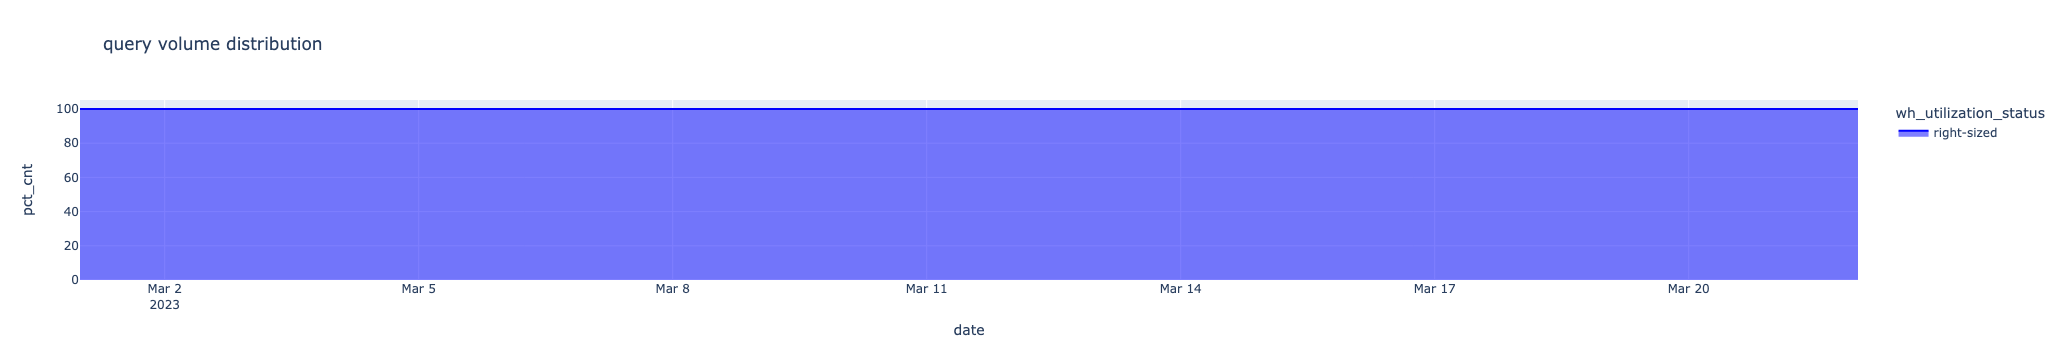

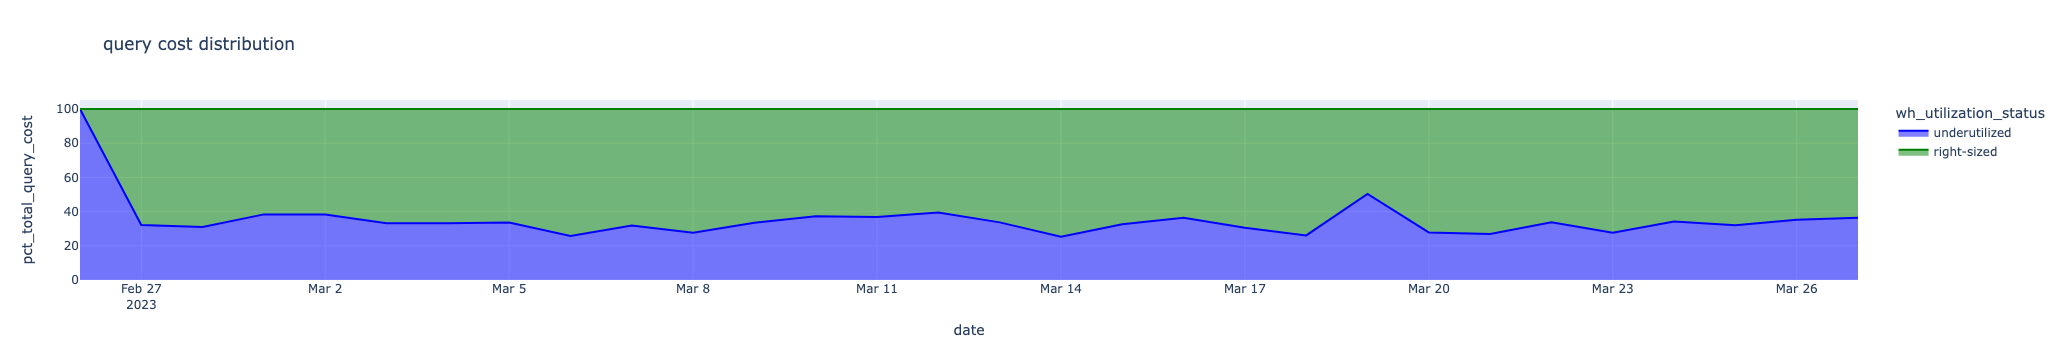

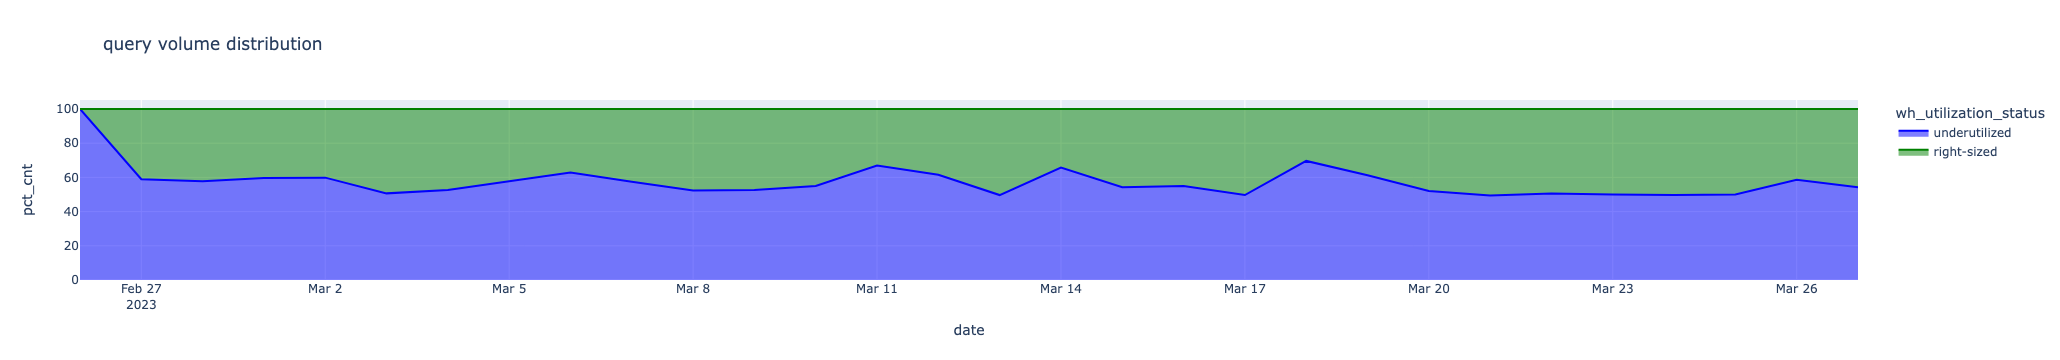

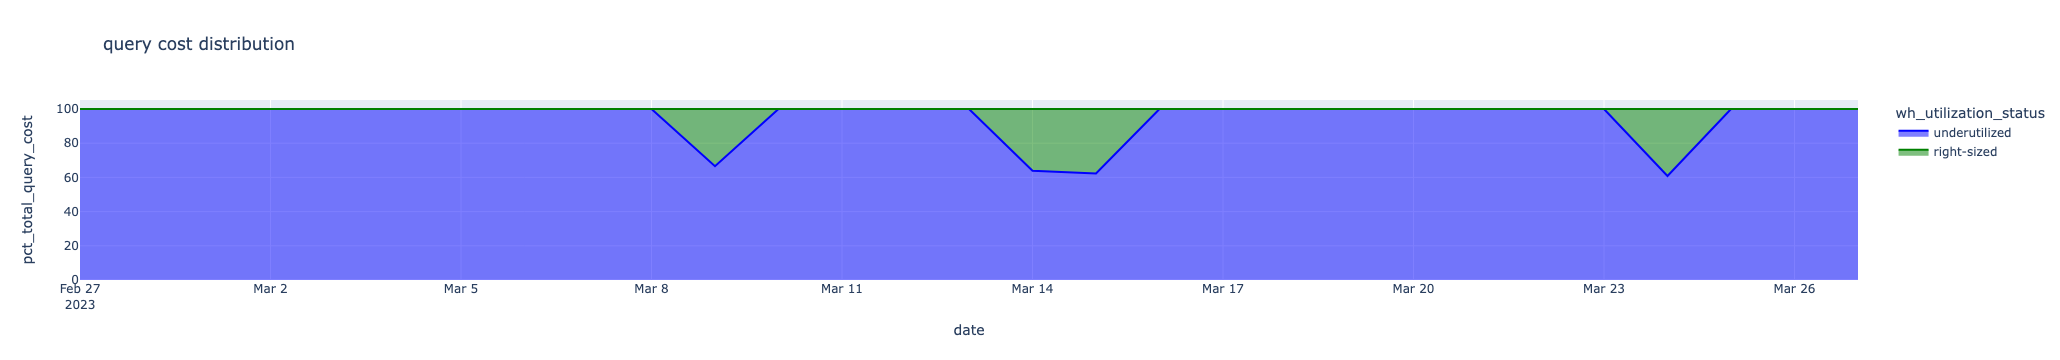

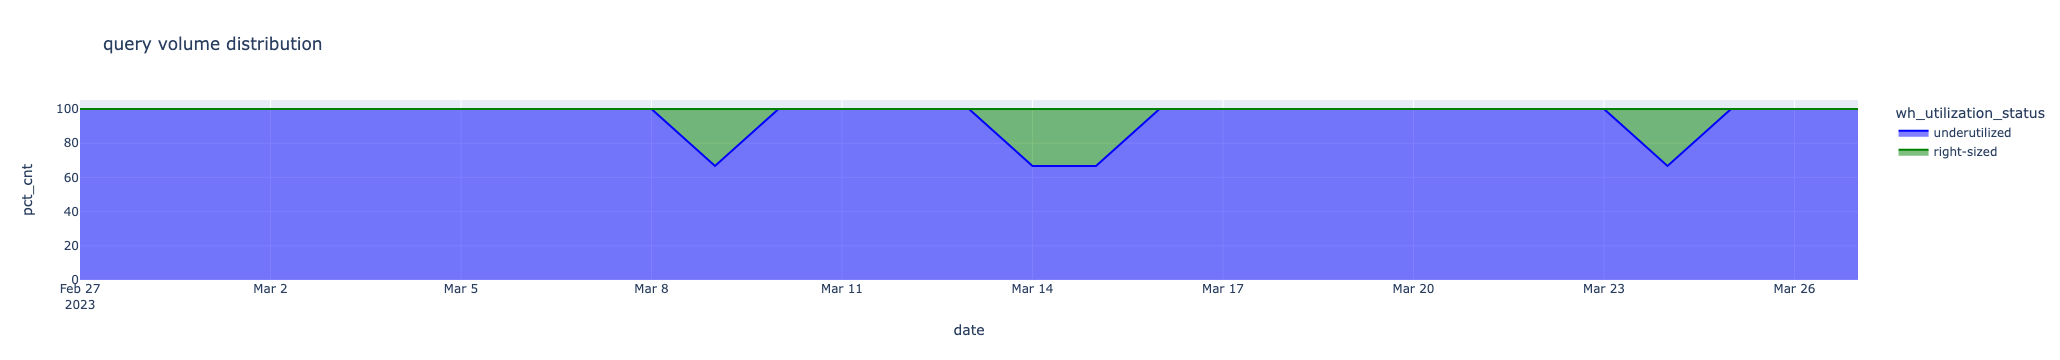

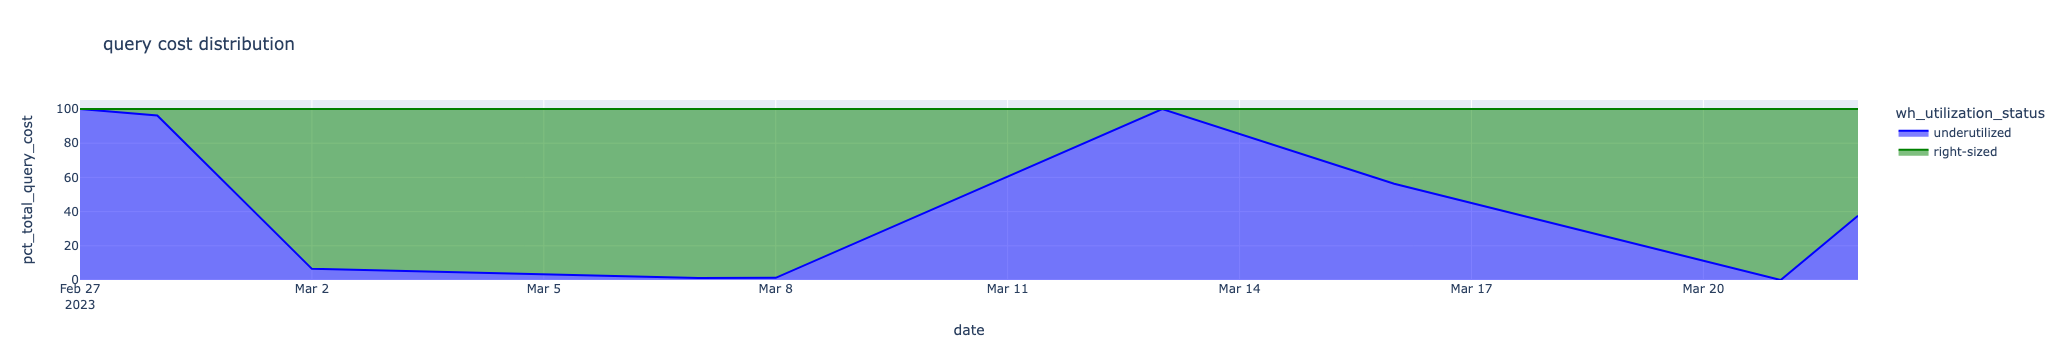

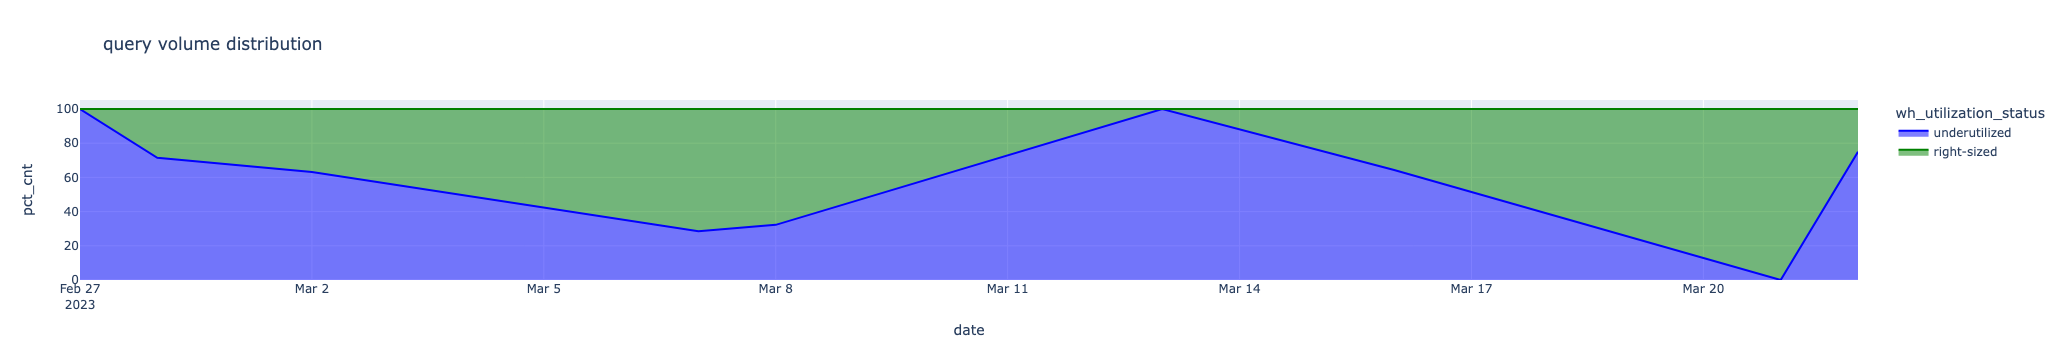

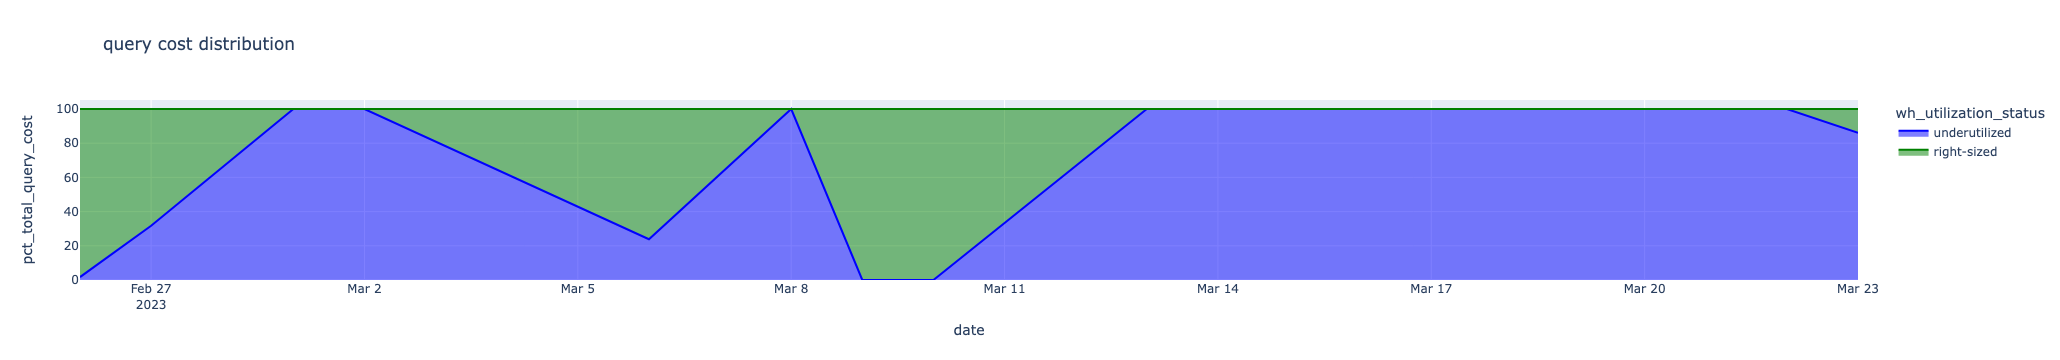

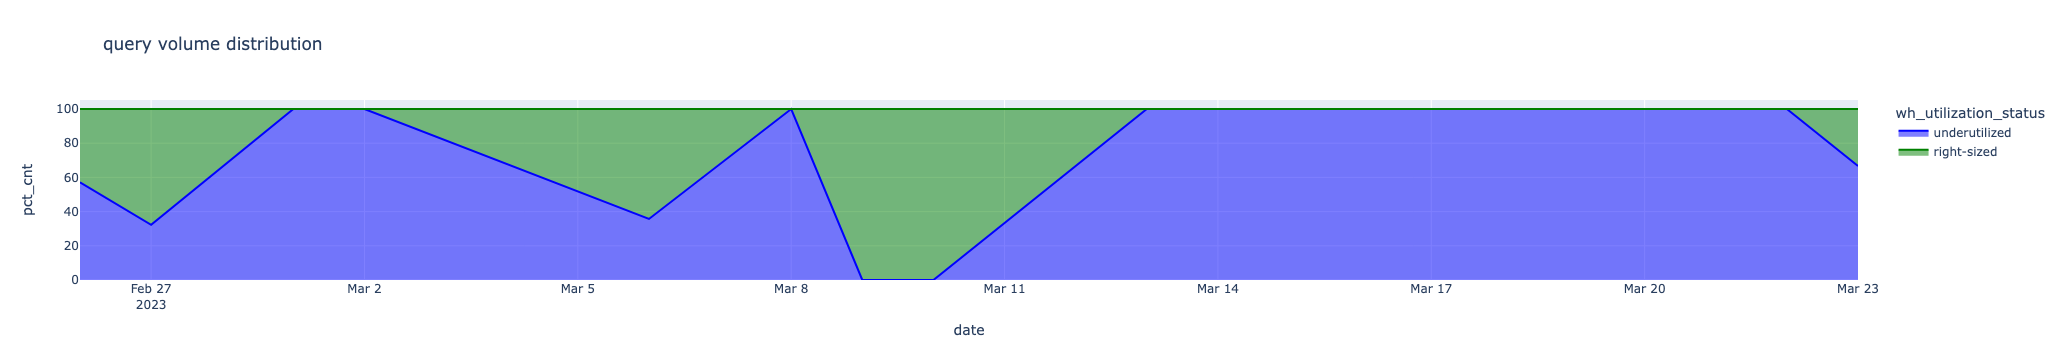

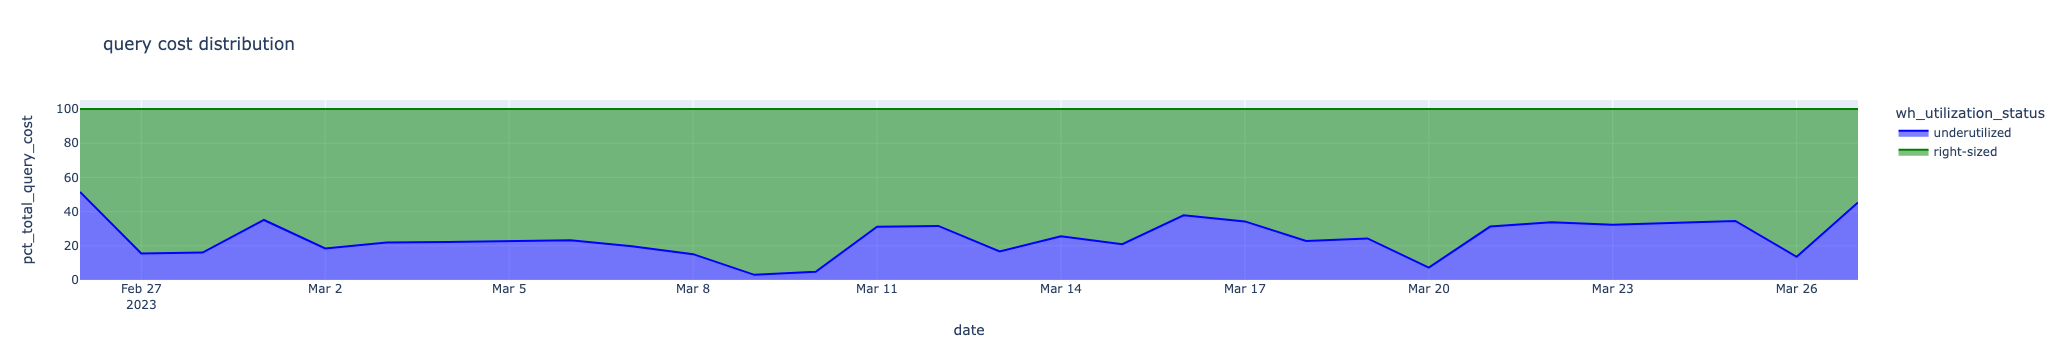

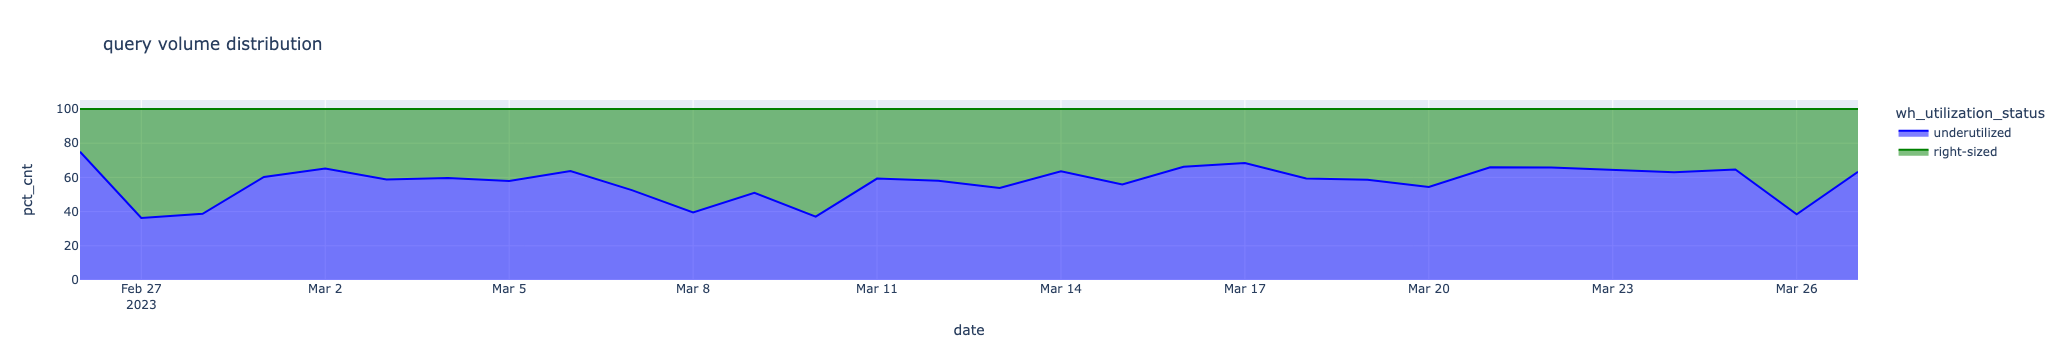

In [27]:

warehouses = df.warehouse_name.unique()
for wh in warehouses[0:10]:

    fig = px.area(
        df[df.warehouse_name == wh], 
        x="date", 
        y="pct_total_query_cost", 
        color = 'wh_utilization_status', 
        color_discrete_sequence=['blue', 'green', 'red'],
        title = "query cost distribution"
    )
    fig.update_layout(hovermode="x")
    fig.show()

    fig = px.area(
        df[df.warehouse_name == wh], 
        x="date", y="pct_cnt", 
        color = 'wh_utilization_status', 
        color_discrete_sequence=['blue', 'green', 'red'],
        title = "query volume distribution"
    )
    fig.update_layout(hovermode="x")

    fig.show()